## CT5133 / CT5145 Deep Learning (/Online) 2022-2023

## Assignment 2

## James McDermott

* Student ID(s): 22224352
* Student name(s): ADITI VILAS SONKUSARE

**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [29]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [30]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [31]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

This is 1 channel, so we omit it (268, 182) 290031.jpg
This is 1 channel, so we omit it (268, 182) 294266.jpg
This is 1 channel, so we omit it (268, 182) 30337.jpg
This is 1 channel, so we omit it (268, 182) 3626440.jpg
This is 1 channel, so we omit it (268, 182) 50192.jpg
This is 1 channel, so we omit it (268, 182) 54880.jpg
This is 1 channel, so we omit it (268, 182) 57006.jpg


In [32]:
img_array = np.array(images)

In [33]:
img_array.shape

(1254, 268, 182, 3)

In [34]:
# read the csv
df = pd.read_csv("Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [35]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [36]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [37]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [38]:
df4.shape # 1254 rows matches the image data shape above

(1254, 6)

In [39]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]

In [40]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')
    plt.show()

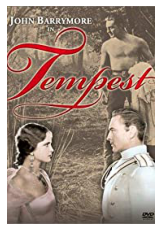

In [41]:
imshow(imread(19451))

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [42]:
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input # importing VGG16 and the preprocess_input
from keras.preprocessing import image

#created an empty to store the preprocessed images
image = []

# looping over every image and using preprocess_input 
# function from VGG16 model and then preprocessed images are appended to the empt list.
for img in img_array:
    image.append(preprocess_input(img/255))

# Loading the model, target size for VGG16 model is 
model = VGG16(weights='imagenet', include_top=False, input_shape=(268, 182, 3))

# getting the output tensor from the model
x = model.output

# flattening the output tensor and 
prediction = keras.layers.Flatten()(x)

# creating a new model
model = keras.Model(model.input, prediction)

# getting the summary of the new model
model.summary()

# initialising the size of embedding vector:
embedding_size = 512

# getting the number of images
n_movies = len(img_array)
embedding_size = 512 # YOUR CODE HERE

# storing the vectors from the vgg model in a 2D array of zeroes
# where n_movies is the row and embedding_size is the columns
embedding_tensor = np.zeros((n_movies, embedding_size))

# printing shape of new 2D tensor
print(embedding_tensor.shape)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 268, 182, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 268, 182, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 268, 182, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 134, 91, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 134, 91, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 134, 91, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 67, 45, 128)       0   

In [43]:
output = model.predict(np.array(image))

40/40 [==============================] - 172s 4s/step


In [44]:
output.shape

(1254, 20480)

In [45]:
#! pip install torch
import torch
final = torch.tensor(output)

In [46]:
final.shape

torch.Size([1254, 20480])

In [47]:
IDs

[1000771,
 100148,
 1001540,
 100200,
 1002563,
 100485,
 100625,
 100637,
 100666,
 1007920,
 100835,
 100924,
 100931,
 101244,
 101254,
 101268,
 101444,
 101479,
 1016307,
 101640,
 1017456,
 101805,
 1018887,
 102210,
 1022606,
 102343,
 102396,
 102583,
 102701,
 102847,
 102913,
 1031969,
 103243,
 1034325,
 1037223,
 103827,
 1038913,
 104054,
 1043585,
 104652,
 1046997,
 104743,
 1047517,
 104812,
 104839,
 1049405,
 105197,
 1052003,
 1054112,
 105459,
 105500,
 105622,
 105660,
 105916,
 1060277,
 106215,
 106267,
 106305,
 106505,
 106559,
 106664,
 1068643,
 107004,
 1071875,
 107277,
 1073666,
 107444,
 107492,
 107529,
 1075747,
 107688,
 1077262,
 107798,
 107978,
 1080695,
 108435,
 108592,
 108633,
 108656,
 1090674,
 1092014,
 109219,
 109361,
 109422,
 1095442,
 109552,
 109688,
 109891,
 110623,
 110712,
 111040,
 111667,
 111701,
 1117667,
 1118665,
 1119178,
 112368,
 112442,
 112602,
 112609,
 112712,
 112747,
 113125,
 1132593,
 113448,
 113556,
 113649,
 1136

### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [84]:
import math
from sklearn.metrics.pairwise import cosine_similarity

def k_nearest(emb_img, k):
    
    image_embedding = [final[i] for i, idx in enumerate(IDs) if idx == emb_img]    
    
    distance = []
    for ids, embedding in enumerate(final):
        distance.append(cosine_similarity(embedding.reshape(1,-1), image_embedding[0].reshape(1,-1)))

    arr = sorted(distance, reverse=True)[1:k+1]
    
    k_images_ids = [IDs[i] for i, score in enumerate(distance) if score in arr]
    
    return k_images_ids

### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


Image:


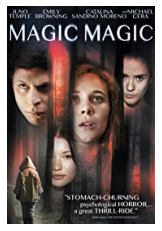

Same Images


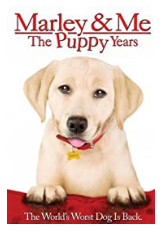

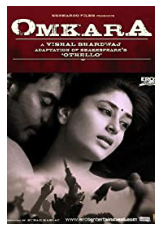

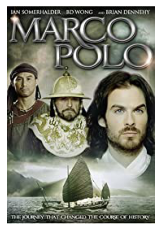

In [85]:
img_ids = k_nearest(1929308, 3)

print("Image:")
imshow(imread(1929308))

print("Same Images")
for img in img_ids:
    imshow(imread(img))

Image:


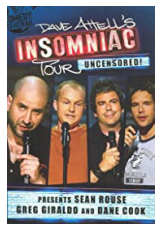

Same Images


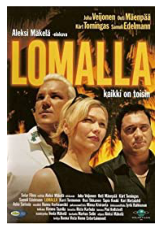

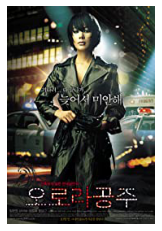

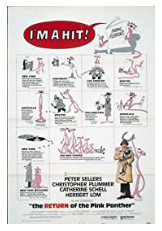

In [86]:
img_ids = k_nearest(1869360, 3)

print("Image:")
imshow(imread(1869360))

print("Same Images")
for img in img_ids:
    imshow(imread(img))

Image:


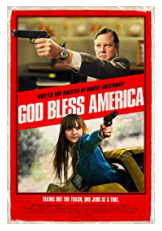

Same Images


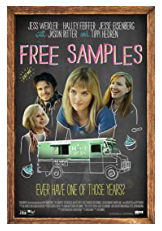

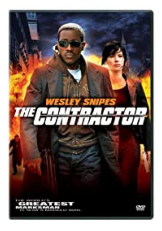

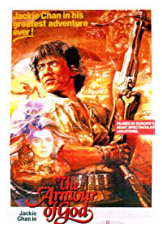

In [87]:
img_ids = k_nearest(1912398, 3)

print("Image:")
imshow(imread(1912398))

print("Same Images")
for img in img_ids:
    imshow(imread(img))

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [ ]:
### YOUR CODE HERE

years = df4[['Year']]

In [ ]:
years = years.to_numpy()

In [ ]:
X_train = final.numpy()[0:865]
y_train = years[0:865]

X_test = final.numpy()[866:1050]
y_test = years[866:1050]

X_val = final.numpy()[1051:]
y_val = years[1051:]

In [ ]:
final.numpy()[0:877].shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(units= 4096, input_shape = (20480, ),activation="relu"))
model.add(Dense(units= 2048, activation="relu"))
model.add(Dense(units= 1024, activation="relu"))
model.add(Dense(units= 512, activation="relu"))
model.add(Dense(units= 1, activation="linear"))

model.compile(optimizer= Adam(1e-3), loss="mae", metrics=["mae"])

model.summary()

In [ ]:
model.fit(X_train, y_train, epochs= 10, validation_data=(X_val, y_val))

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [ ]:
### YOUR CODE HERE
X_train = img_array[0:865]

X_test = img_array[866:1050]

X_val = img_array[1051:]

In [ ]:
img_array.shape

In [ ]:

model = Sequential()
model.add(Conv2D(filters= 16, input_shape = (268, 182, 3), kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size= 2))
model.add(Conv2D(filters= 32, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size= 2))
model.add(Conv2D(filters= 64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size= 2))
model.add(Flatten())
model.add(Dense(units= 4096,activation="relu"))
model.add(Dense(units= 2048, activation="relu"))
model.add(Dense(units= 1024, activation="relu"))
model.add(Dense(units= 512, activation="relu"))
model.add(Dense(units= 1, activation="linear"))

model.compile(optimizer="adam", loss = "mae", metrics=["mae"])

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val))